# Data Augmentation

In this notebook, we create some data augmentation usefull for the challenge that doesn't exist by default in the fastai library. The augmentation that we will do on the images must be carefully picked because applying the wrong transformation on a REAL face can make it appear FALSE. We currently implemented:


- Gaussian Blur
- Poisson + Gaussian noise (the closest from photography noise)
- JPG compression artifacts
- Downscaling

/!\ It is important to ut the transforms in the correct order (the one appearing physically), otherwise some will interact (e.g noise then blurring)

In [2]:
from fastai.core import *
from fastai.vision import *
import torch
from efficientnet_pytorch import EfficientNet
import albumentations as A
import cv2

### Get the Data

In [3]:
img = open_image('../data1/cropped_faces/train/rjgvngaopm.mp4_0_REAL.jpg')

In [4]:
def tensor2np(x):
    np_image = x.cpu().permute(1, 2, 0).numpy()
    np_image = (np_image * 255).astype(np.uint8)
    
    return np_image

def alb_tfm2fastai(alb_tfm, order):
    def _alb_transformer(x):
        # tensor to numpy
        np_image = tensor2np(x)

        # apply albumentations
        transformed = alb_tfm(image=np_image)['image']

        # back to tensor
        tensor_image = pil2tensor(transformed, np.float32)
        tensor_image.div_(255)

        return tensor_image

    transformer = TfmPixel(_alb_transformer, order=order)
    
    return transformer()

## Original Image

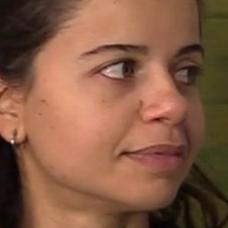

In [5]:
img

## Motion Blur Transform

In [6]:
MotionBlur = [alb_tfm2fastai(A.MotionBlur(blur_limit=9, p=1.), order=11)]

In [7]:
aug_img = img.apply_tfms(MotionBlur)

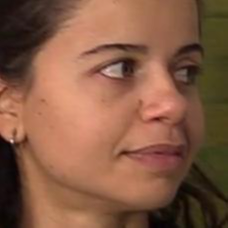

In [8]:
aug_img

## Photography Noise

Consists of 2 types of noise:
- Poisson ([implementation](https://github.com/scikit-image/scikit-image/blob/master/skimage/util/noise.py))
- Gaussian ([implementation](https://github.com/CSBDeep/CSBDeep/blob/master/csbdeep/data/transform.py))

In [9]:
GaussNoise = [alb_tfm2fastai(A.GaussNoise(var_limit=(15.0, 100.0), p=1.), order=12)]

In [10]:
aug_img = img.apply_tfms(GaussNoise)

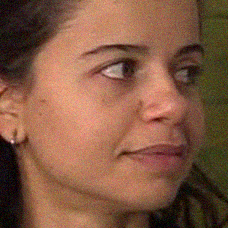

In [11]:
aug_img

## JPG Compression Artifacts

We have to add a jpg compression data augmentation as some compression will be applied on the test set. Fastai's transforms applies transforms on tensors, so we have to transforms them back to PIL Images as I don't think we can simulate JPEG compression directly on tensors.

In [12]:
JpegCompression = [alb_tfm2fastai(A.JpegCompression(p=1., quality_lower=30), order=13)]

In [13]:
aug_img = img.apply_tfms(JpegCompression)

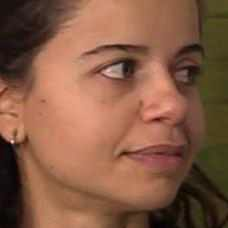

In [14]:
aug_img

## Downscaling

Albumentation downscaling is broken as they use the same interpolation both for downsampling and upsampling, leading to undesired artifacts (aliasing/Moiré effects).

In [29]:
def _downscale(x, scale=0.5):
      
    tensor = x.cpu().permute(1, 2, 0).numpy()
    
    h, w = img.shape[1:]
    
    downscaled = cv2.resize(tensor, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
    upscaled = cv2.resize(downscaled, (h,w), interpolation=cv2.INTER_CUBIC)
    x = torch.tensor(upscaled, dtype=torch.float32).permute(2,0,1)
    x.clamp_(0,1)
    return x

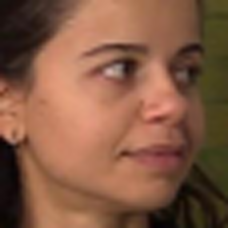

In [30]:
Image(_downscale(img.data))

In [19]:
downscale = TfmPixel(_downscale, order=14)

## Get the data

In [23]:
tfms = []
tfms += [alb_tfm2fastai(A.MotionBlur(blur_limit=9, p=.25), order=11)]
tfms += [alb_tfm2fastai(A.GaussNoise(var_limit=(15.0, 75.0), p=.25), order=12)]
tfms += [alb_tfm2fastai(A.JpegCompression(p=.25, quality_lower=30), order=13)]
tfms += [downscale(scale=0.5, p=.25)]

In [20]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [31]:
bs, sz = 32, 256
path = Path('../data1/cropped_faces')

src = ImageList.from_folder(path).split_by_folder(train='train', valid='valid')

def get_data(bs,size):
    data = (src.label_from_re('([A-Z]+).jpg$') 
        .transform(get_transforms(xtra_tfms=tfms),size=size)
        .databunch(bs=bs, device=device).normalize(imagenet_stats))
    return data

In [32]:
data = get_data(bs, sz)

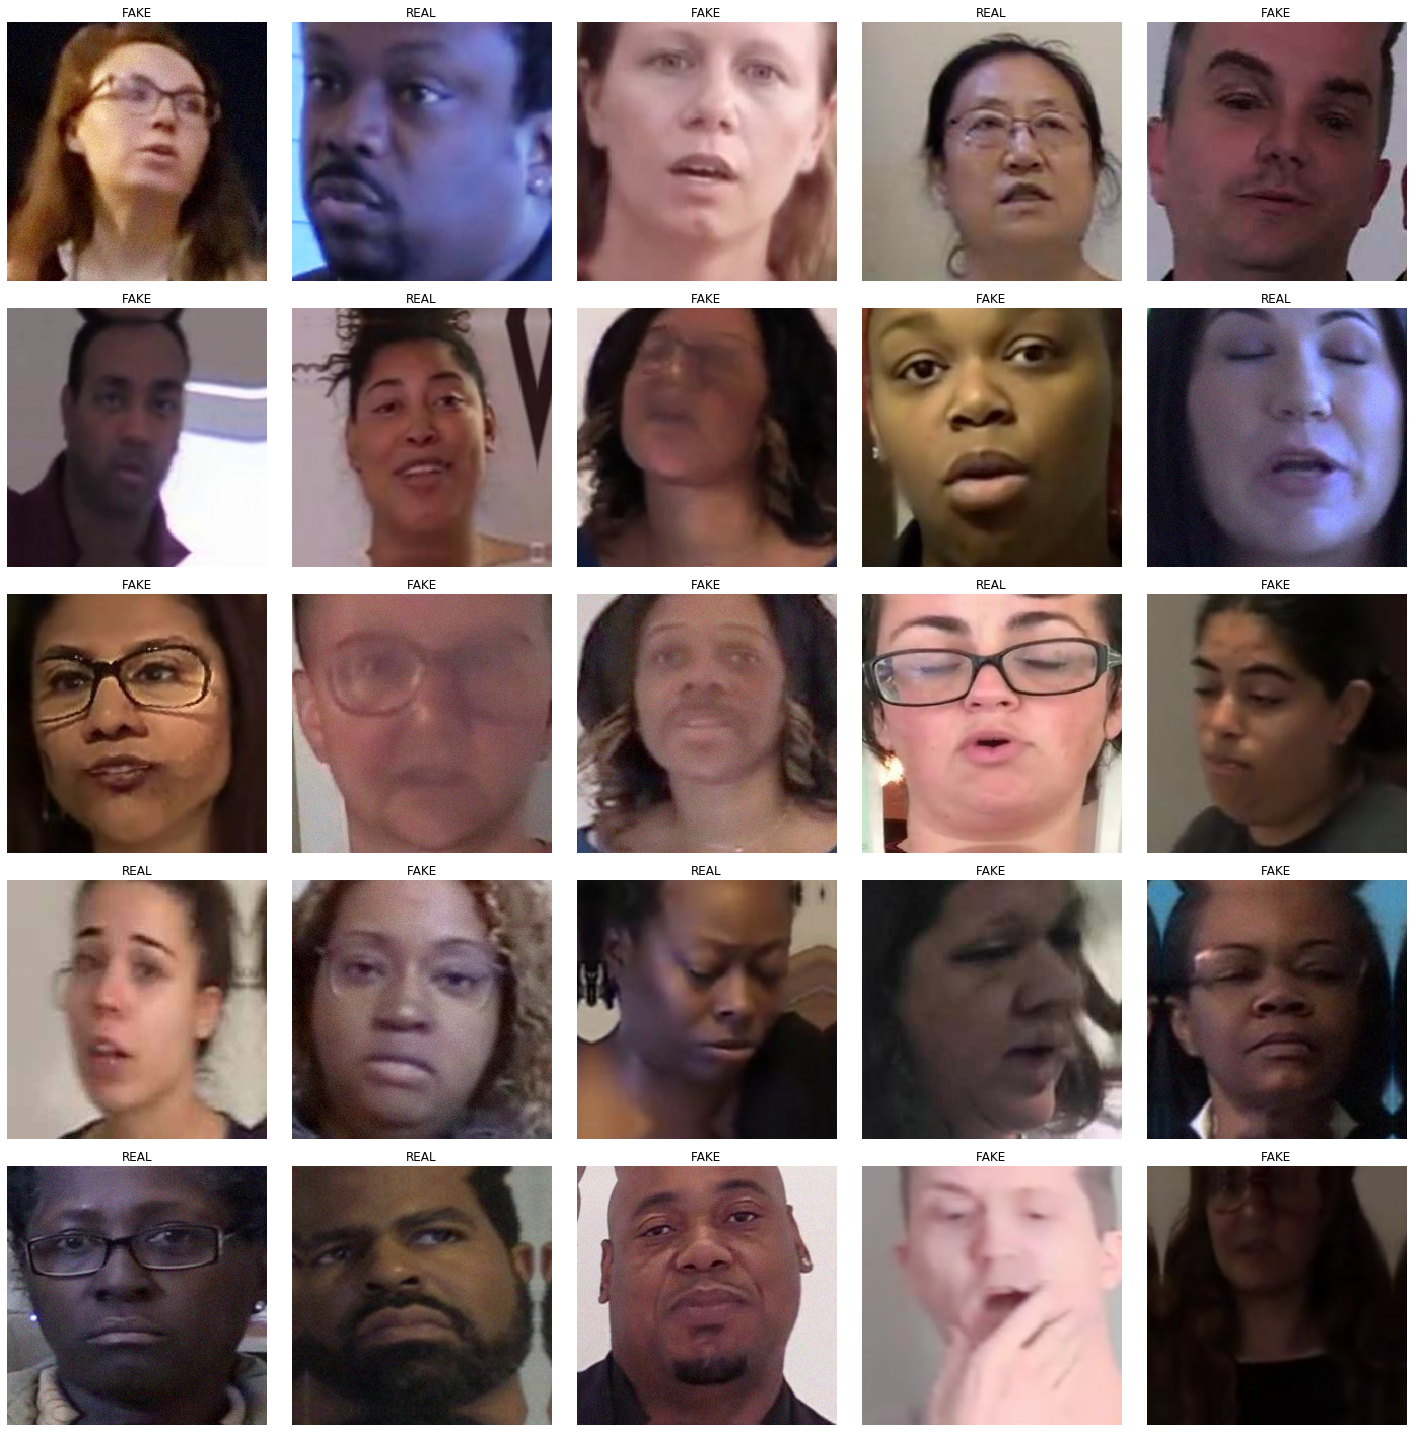

In [33]:
data.show_batch()

In [34]:
model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=data.c)
learn = Learner(data, model, metrics=[accuracy])

Loaded pretrained weights for efficientnet-b1


In [35]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.298896,0.228816,0.898927,08:21
